# Image generation (plus some gold mining)

In [1]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib.pyplot as plt

from units import *
from simulation import SubhaloSimulator

## Parameters

In [16]:
alpha_mean = 2e8/M_s
alpha_std = 0.2e8/M_s

beta_mean = -1.9
beta_std = 0.05

n_sims = 9

In [17]:
alpha = np.random.normal(loc=alpha_mean, scale=alpha_std, size=n_sims)
beta = np.random.normal(loc=beta_mean, scale=beta_std, size=n_sims)

assert np.min(alpha) > 0.
assert np.max(beta) < -1.

In [18]:
alpha_ref = alpha_mean
beta_ref = beta_mean

## Generate data

In [19]:
sim = SubhaloSimulator()

In [20]:
images = sim.rvs(alpha, beta, n_sims)

## A first look at the data

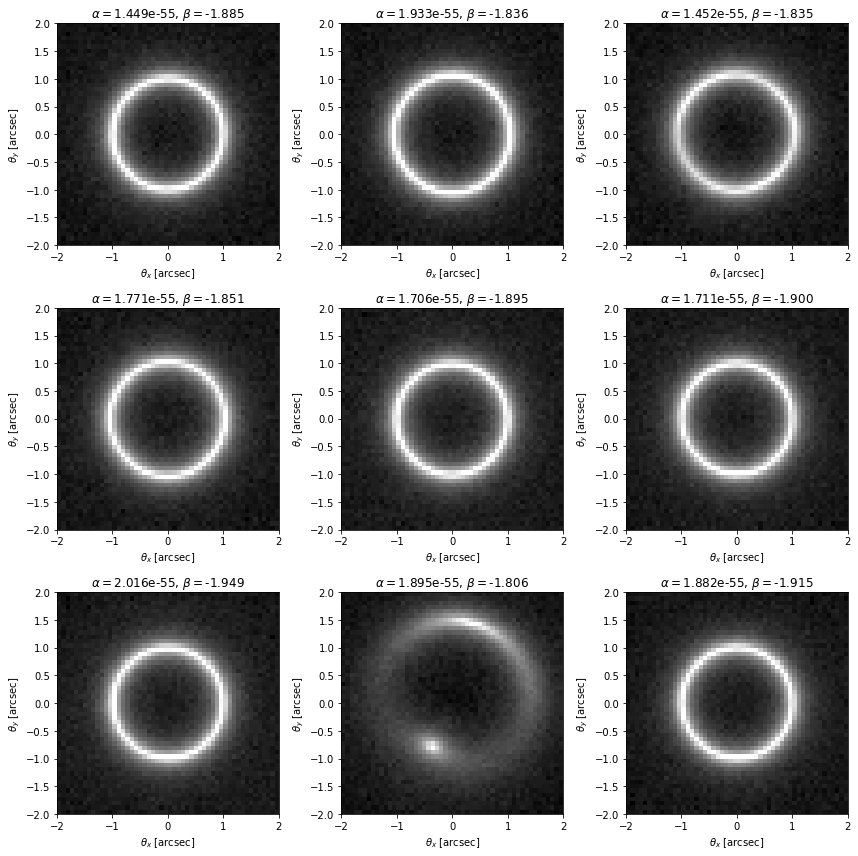

In [29]:
plt.figure(figsize=(12,12))

for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(np.log10(images[i]), vmax=3.5, cmap='gist_gray', extent=(-2.,2.,-2.,2.), origin="lower")
    plt.xlabel(r"$\theta_x$ [arcsec]")
    plt.ylabel(r"$\theta_y$ [arcsec]")
    plt.title(r"$\alpha = ${:.3e}, $\beta = ${:.3f}".format(alpha[i], beta[i]))
    
plt.tight_layout()
plt.show()